
# Use a pretrained model to get more focal examples from the recordings we have on disk

The clips we've used so far for model training were taken from human labelled tags in wildtrax. Some of the tagging strategies are to only tag the first instance of an individual bird's vocalization within a given time period. This first vocalization might not necessarily be the loudest or the clearest, as there are possibly more un-tagged vocalizations in that time period. By using the model we have already trained, we can search the rest of the recordings for focal examples of the focal species calls. 

In [24]:
from pathlib import Path
import pandas as pd
import sys
BASE_PATH = Path.cwd().parent.parent
model_save_path = BASE_PATH / "models"
sys.path.append(str(BASE_PATH))
import opensoundscape as opso
from opensoundscape import Audio, Spectrogram, SpectrogramPreprocessor, 
from opensoundscape.preprocess.utils import show_tensor
import torch
from opensoundscape.data_selection import resample
from src.utils import get_hash_from_df
import matplotlib.pyplot as plt


# Load the labelled dataset from disk


In [25]:
data_path = Path.cwd().parent.parent / "data"
train_df = pd.read_pickle(data_path / "interim" / "train_set" / "train_set_verified.pkl")

In [37]:
train_files = train_df.index.get_level_values("file").values

In [41]:
full_training_recordings = opso.AudioSplittingDataset(train_files, preprocessor=opso.SpectrogramPreprocessor(3.0), overlap_fraction=0.5)

In [46]:
all_samples_df = full_training_recordings.label_df

# skip over this if the training set cheking has already begun

# Load the model to make predictions on the training dataframe

In [43]:
# Load the model saved at the end of the model training notebook
model = opso.cnn.load_model(model_save_path / "whole-aardvark-191.model")

In [44]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
all_predictions = model.predict(all_samples_df, batch_size=64, activation_layer="sigmoid")

  0%|          | 0/85070 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
predictions.rename(columns={"target_present": "predicted"}, inplace=True)
predictions.head()

predicted
file                                              start_time end_time           
../../data/raw/recordings/OSFL/recording-4315.mp3 0.0        3.0        0.270915
                                                  1.5        4.5        0.118851
                                                  3.0        6.0        0.084408
                                                  4.5        7.5        0.166583
                                                  7.5        10.5       0.824483

In [8]:
# sample_train_df_with_preds = pd.concat([sample_train_df, predictions], axis=1)
df = pd.concat([df, predictions], axis=1)
# df = df.loc[~df.probability.isna()]

In [9]:
df["loss"] = calculate_loss(df)

In [10]:
# add a column to the dataframe to store the confidence of the label, if it doesn't alredy exist
if 'confidence_cat' not in df.columns:
    df['confidence_cat'] = 0
idx = 0
confidence = 0 # 0 means unchecked. 

In [11]:
df.sample()

,,,present,probability,loss,confidence_cat
file,start_time,end_time,,,,
../../data/raw/recordings/OSFL_other_habitats/recording-98067.mp3,222.0,225.0,0.0,0.130419,0.130419,0


# If cleaning has begun, load the verified data instead

In [7]:
other_habitats_label_df_verified = pd.read_pickle(data_path / "interim" / "train_and_valid_set" / "other_habitats_label_df_verified.pkl")
other_habitats_label_df_verified.sample()

,,,present,probability,loss,confidence_cat
file,start_time,end_time,,,,
../../data/raw/recordings/OSFL_other_habitats/recording-389216.flac,109.5,112.5,0.0,0.068288,0.068288,0


In [58]:
def verify_samples(df: pd.DataFrame, target=0.0, loss_sorted=False, autolabel=False, index=0, include_verified=False):
    # Filter the split dataset further into unverified and present tags.
    if include_verified:
        unverified=df
    else:
        unverified = df[df['confidence_cat'] == 0]

    unverified_target_clips = unverified.loc[unverified['present'] == target]
    if len(unverified_target_clips) == 0:
        print("No unverified clips within chosen target class.")
        return df
    
    if loss_sorted:
        # Sort the unverified clips by the loss value.
        unverified_target_clips = unverified_target_clips.sort_values(by='loss', ascending=False)

    # Set the confidence cat to 0 so that any skipped clips or crashes don't get saved as previous confidence.
    user_confidence = 0

    clip_idx = unverified_target_clips.index[index]
    path, offset, end_time = clip_idx
    duration = end_time - offset
    audio = Audio.from_file(path, offset=offset, duration=duration)
    spec = Spectrogram.from_audio(audio)
    print(f"target = {df.loc[clip_idx].present}, prediction = {df.loc[clip_idx].probability} loss = {df.loc[clip_idx].loss}")
    audio.show_widget(autoplay=True)

    spec.plot()
    if autolabel:
        label = input("press enter to autolabel")
        if label:
            user_confidence = label
        else:
            user_confidence = autolabel

    elif not autolabel:
        user_confidence = input("enter confidence: 1=Discard, 2=Unsure, 3=Verified, 4=Focal, 5=Re-label-as-OSFL, 6=Re-label-as-absent")

    # save the user input confidence back to the original dataframe.
    df.loc[clip_idx, 'confidence_cat'] = int(user_confidence)
    
    # display the counts
    print(f"added confidence tag {user_confidence} to the dataframe.")
    print(df.loc[df.present == target].confidence_cat.value_counts())

    return df


# Label the test set with confidence scores
This part of the notebook 

- takes a test set saved to disk as an AudioFileDataset (or just a pandas dataframe)
- loads each sample with playback option
- takes a user typed label as input
- saves the label in a column of the dataframe titled 'confidence' 
- saves the dataset back to disk



# Run this line and pass in a dataframe to verify samples. 

target = 0.0, prediction = 0.8838611841201782 loss = 0.8838611841201782


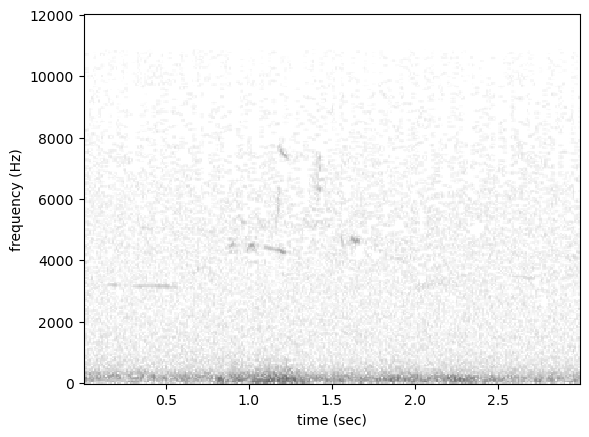

added confidence tag 3 to the dataframe.
confidence_cat
0    167274
3      1012
5       103
2        40
1         2
Name: count, dtype: int64


/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_22695/1352026938.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, 'confidence_cat'] = int(user_confidence)


In [1235]:
other_habitats_label_df_verified = verify_samples(df, target=0.0, loss_sorted=True, index=0, include_verified=False)


In [920]:
# Correct a typo in the confidence_cat column

other_habitats_label_df_verified.loc[other_habitats_label_df_verified.loss==0.9077584147453308, 'confidence_cat'] = 5

# Show the distribution of loss
The loss histogram shows that from the 1000 recordings taken from outside of the OSFL habitat, and therefore from outside of the initial training set, a large majority of these samples predicted OSFL presence with a score below 0.5. The total number of 3 second clips generated buy these 1000 recordings is 167274. 

93% of the clips scored below 0.5 and 98.5% scored below 0.8. 

A model trained on data from OSFL habitats only was used to make predictions on all of these clips. The clips were assumed all to have OSFL presence of 0, and all the clips were sorted by loss, or 'most confusing'. The most erroneous 1157 clips were manually verified. These top 1157 clips scored around 0.8 and above. 

1157 total verified clips:  <br>
1012 Actual absent      <br>
103 Actual OSFL        <br>
40 Uncertain          <br>
2 Discarded          <br>

Text(0, 0.5, 'Count')

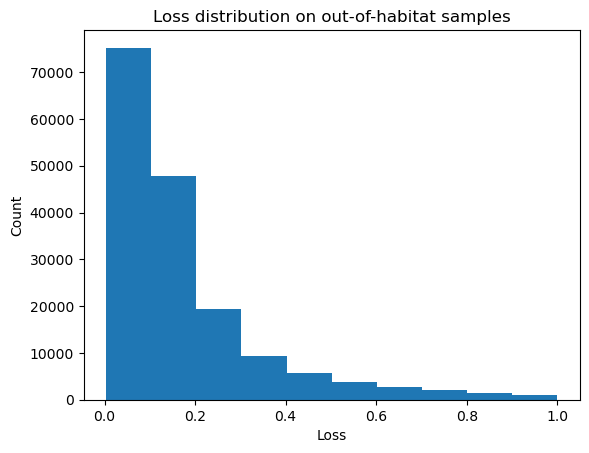

In [1257]:
plt.hist(other_habitats_label_df_verified.loss)
plt.title("Loss distribution on out-of-habitat samples")
plt.xlabel("Loss")
plt.ylabel("Count")

In [1250]:
sum(other_habitats_label_df_verified.loss < 0.8)/len(other_habitats_label_df_verified)

0.9852758696439492

# Show how the frequency of actual OSFL samples decreases with score

<Axes: >

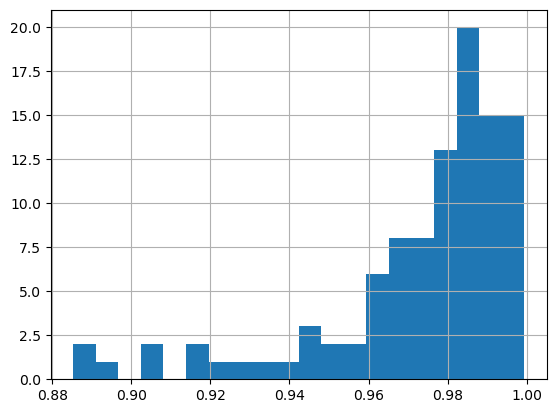

In [20]:
df = other_habitats_label_df_verified
df.loc[df.confidence_cat == 5].probability.hist(bins=20)

In [21]:
other_habitats_label_df_verified.sample()

,,,present,probability,loss,confidence_cat
file,start_time,end_time,,,,
../../data/raw/recordings/OSFL_other_habitats/recording-20095.mp3,493.5,496.5,0.0,0.738583,0.738583,0


After picking the 1000 most confusing 3 second clips from the recordings from other habitats, 289 unique locations end up being represented. This is because some recordings contain multiple segments of audio which are similar to the target vocalization. 

In [23]:
df[df.confidence_cat == 3].index.get_level_values('file').nunique()

289

# Save the validation work
This will save the training dataframe with a new column called 'confidence cat' which will show an extra layer of error checking, and allow us to re-label mislabelled samples. 


In [1259]:
other_habitats_label_df_verified.to_pickle(data_path / "interim" / "train_and_valid_set" / "other_habitats_label_df_verified.pkl")

In [1260]:
other_habitats_label_df_verified.confidence_cat.value_counts()

confidence_cat
0    167274
3      1012
5       103
2        40
1         2
Name: count, dtype: int64

# Clean the absence class too, then submit a report of the cleaning time and the categories after cleaning into a report. 
Cleaning 1000 samples takes about 4-5 hours. 

absence set confusers: 
- hermit thrush teer
- Western Wood-Pewee - Contopus sordidulus


presence set confusers: 
- say's phoebe (perhaps)
